![](https://drive.google.com/uc?export=view&id=1rqx5wh7U-8OdKlr4L38QNGggEXSKyXHC)

---


<h1>5.2 Preprocessing</h1>

## Libraries

Importing all the libraries needed for the analysis and reading the file

In [29]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

In [30]:
warnings.filterwarnings('ignore')

In [31]:
df_all = pd.read_csv('listings.csv')

In [32]:
columns_to_keep = ['id', 'description', 'host_id', 'host_since', 'host_listings_count', 'host_identity_verified', 'host_is_superhost', 'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_365', 'number_of_reviews', 'reviews_per_month', 'last_review', 'instant_bookable']

In [33]:
df = df_all[columns_to_keep]

## Price Preprocessing

Fix the price format and convert it from dollars to euros (1$ = 1.03€)

In [34]:
def price_conversion(x):
  x = float(x.replace(',', '').replace('$', ''))
  return 1.03*x

In [35]:
df['price'] = df['price'].apply(lambda x: price_conversion(x))

## Reviews Preprocessing

Replacing null values with 0 in the columns <i>reviews_per_month</i> and <i>last_review</i> since an empty cell in column <i>reviews_per_month</i> means that the listing has no reviews and accrodingly, the <i>last_review</i> date has no meaning for them

In [36]:
df['reviews_per_month'].fillna(0,inplace = True)
df['last_review'].fillna(0,inplace = True)

In [37]:
df = df[df['bathrooms_text'].notna() & df['beds'].notna() & df['host_is_superhost'].notna()]

## Bedrooms Preprocessing

If the value in column <i>beds</i> is 0, then, the function returns the value 0 in the corresponding place in column <i>bedrooms</i> while if the value in column <i>beds</i> is 2, then, the value 1 is returned in column <i>bedrooms</i>. This based on the logic that if there are at least two bed, then there must be one bedroom in the Airbnb. We didn't apply the same logic when the number of beds is 1 because in this case, the Airbnb could be a studio, thus there will be 0 bedrooms

In [38]:
def bedrooms(x,y):
  if y == 0:
    return 0
  elif y == 2:
    return 1
  else:
    return x

In [39]:
df['bedrooms'] = df.apply(lambda x: bedrooms(x['bedrooms'], x['beds']), axis=1)

## Bathrooms Preprocessing

Seperating text from numeric values of column <i>bathrooms_text</i> and storing the corresponding values into two new columns, <i>bathroom_type</i> and <i>bathroom</i>

In [40]:
def bathroom_type(x):
  if 'shared' in x.lower():
    return 'shared'
  return 'private'

In [41]:
df['bathroom_type'] = df['bathrooms_text'].apply(lambda x: bathroom_type(x))

In [42]:
df['bathrooms_text'] = df['bathrooms_text'].apply(lambda x: '0.5 bath' if 'half' in x.lower() else x)

In [43]:
df['bathroom'] = df['bathrooms_text'].apply(lambda x: float(str(x).split(" ")[0]))

## Host_total_count_listings Preprocessing

In [44]:
df['host_listings_count'] = df['host_listings_count'].apply(lambda x: 1 if x == 0 else x)
df['host_listings_count'].fillna(1, inplace=True)

## Amenities Preprocessing

In [45]:
df['amenities'] = df['amenities'].apply(lambda x: x.replace('"','').replace('[','').replace(']','').split(', '))

In [46]:
amenities_list = []
df.reset_index(inplace=True, drop=True)

for i in range(0, len(df)):
  for j in df['amenities'][i]:
    if j.lower() not in amenities_list:
      amenities_list.append(j.lower())

In [47]:
df['smoke_alarm'] = df['amenities'].apply(lambda x: 1 if 'smoke alarm' in x else 0)
df['oven']= df['amenities'].apply(lambda x: 1 if 'oven' in x else 0)
df['patio_balcony'] = df['amenities'].apply(lambda x: 1 if 'patio or balcony' in x else 0)
df['fire_extinguisher'] = df['amenities'].apply(lambda x: 1 if 'fire extinguisher' in x else 0)
df['shower_gel'] = df['amenities'].apply(lambda x: 1 if 'shower gel' in x else 0)

df['amenities'] = df['amenities'].apply(lambda x: len(x))

In [48]:
q = df['amenities'].quantile([.25, .5, .75, .9])
print(q)

0.25    19.0
0.50    26.0
0.75    33.0
0.90    42.0
Name: amenities, dtype: float64


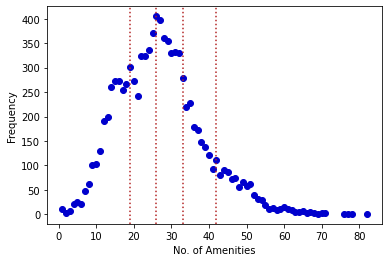

In [49]:
x_plot = list(sorted(df['amenities'].unique()))
y_plot = list(df.groupby('amenities')['amenities'].count())

plt.scatter(x_plot, y_plot, color='mediumblue')
plt.xlabel('No. of Amenities')
plt.ylabel('Frequency')
plt.axvline(x=19, color='firebrick', linestyle='dotted')
plt.axvline(x=26, color='firebrick', linestyle='dotted')
plt.axvline(x=33, color='firebrick', linestyle='dotted')
plt.axvline(x=42, color='firebrick', linestyle='dotted')
plt.show()

In [50]:
def amenities_classes(x):
  if x < 27:
    return 'low'
  elif x < 34:
    return 'medium'
  else:
    return 'high'

In [51]:
df['amenities_category'] = df['amenities'].apply(lambda x: amenities_classes(x))

## Price Statistical Analysis

In this section, we apply the quantile analysis to detect any outliers in the dataset regarding column <i>price</i>

In [52]:
q = df['price'].quantile([.25, .5, .75, .97])
print(q)

0.25     37.08
0.50     51.50
0.75     82.40
0.97    239.99
Name: price, dtype: float64


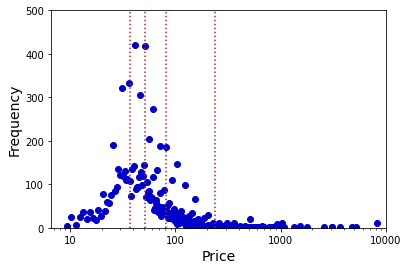

In [53]:
x_plot = list(sorted(df['price'].unique()))
y_plot = list(df.groupby('price')['price'].count())

plt.scatter(x_plot, y_plot, color='mediumblue')
plt.axvline(x=37.08, color='firebrick', linestyle='dotted')
plt.axvline(x=51.5, color='firebrick', linestyle='dotted')
plt.axvline(x=82.4, color='firebrick', linestyle='dotted')
plt.axvline(x=239.99, color='firebrick', linestyle='dotted')
plt.xlabel('Price', fontsize=14)
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.xlim([0,10000])
plt.ylim([0,500])
plt.ylabel('Frequency', fontsize=14)
plt.show()

Box plot of price per room type 

In [54]:
df_mod = df[df['price']<250]

fig = px.box(df_mod, x='room_type', y='price', points="all", notched=True)
fig.show()

## Pearson Correlation among the features

Text(0.5, 1.0, 'Correlation Heatmap')

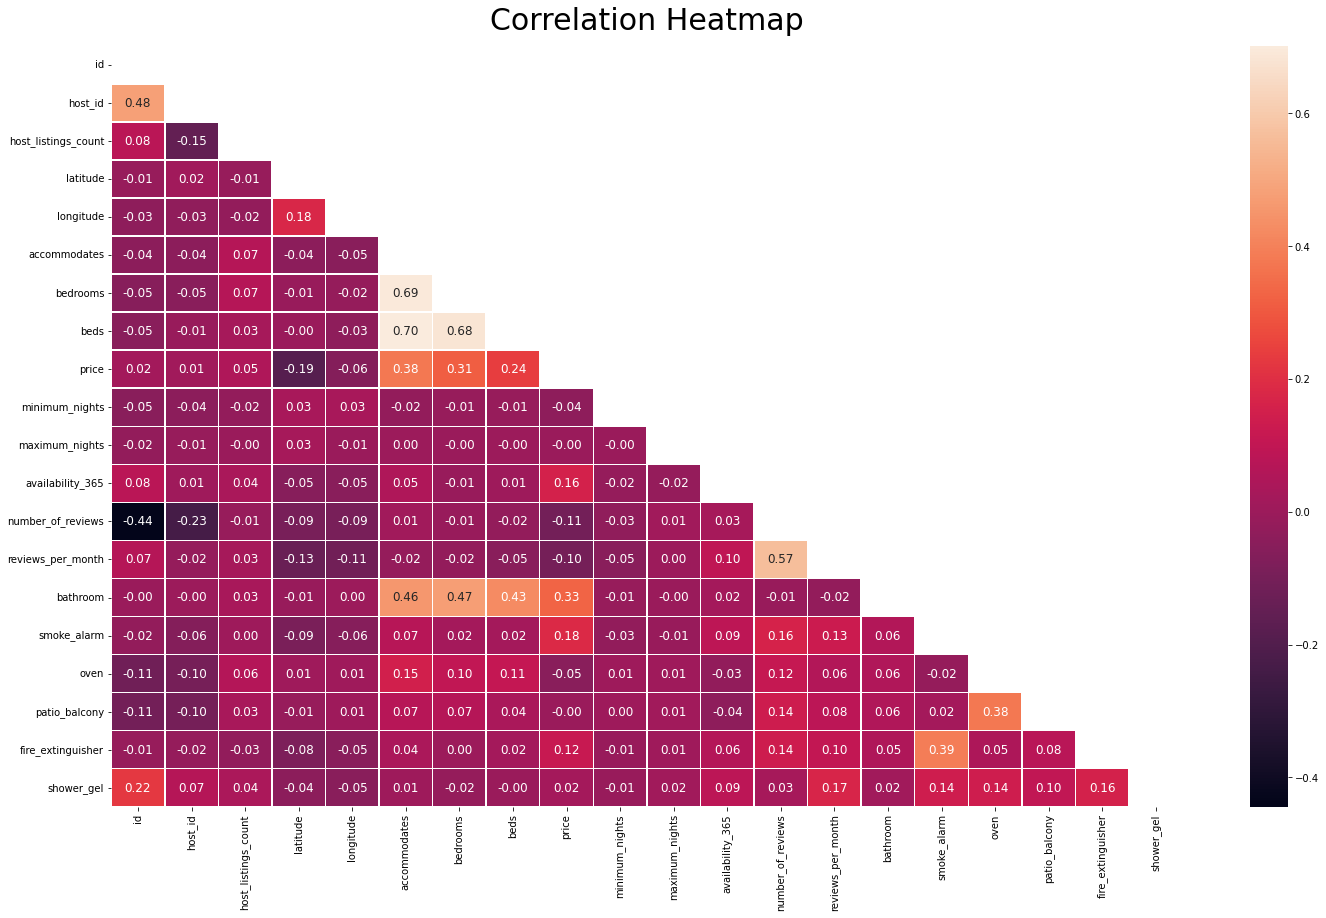

In [ ]:
df_corr = df_mod.corr()
matrix = np.triu(df_corr)
fig, ax = plt.subplots(figsize=(24,14))
heatmap = sns.heatmap(df_corr, linewidths=.5, annot=True, annot_kws={"size":12}, fmt='.2f', mask = matrix)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=16)

## Categorical Features Preprocessing

In [ ]:
df_mod['host_identity_verified'] = df_mod['host_identity_verified'].map({'t': 'True', 'f': 'False'})
df_mod['host_is_superhost'] = df_mod['host_is_superhost'].map({'t': 'True', 'f': 'False'})
df_mod['has_availability'] = df_mod['has_availability'].map({'t': 'True', 'f': 'False'})
df_mod['instant_bookable'] = df_mod['instant_bookable'].map({'t': 'True', 'f': 'False'})

In [ ]:
drop_columns = ['id','description','host_id','host_since','latitude','longitude','property_type','bathrooms_text','bedrooms','has_availability','last_review']
categorical_features = ['host_identity_verified','host_is_superhost','neighbourhood_cleansed','room_type','instant_bookable','bathroom_type','amenities']
numerical_features = ['host_listings_count','accommodates','beds','minimum_nights','maximum_nights','availability_365','number_of_reviews','reviews_per_month','bathroom']
amenities_features = ['smoke_alarm','patio_balcony','oven','fire_extiguinsher','shower_gel']

In [ ]:
df_final = df_mod.copy()
df_final = df_final.drop(drop_columns, axis=1)

In [ ]:
df_final = pd.get_dummies(df_final)

## X, y and train, test datasets splitting

In [ ]:
X = df_final.drop(['price'], axis=1)
y = df_final['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(7382, 73)

## Standardization and Scaling of Numerical Features

In [ ]:
sc = StandardScaler()

X_sc = sc.fit_transform(X_train[numerical_features])
X_sc_test = sc.transform(X_test[numerical_features])

X_train[numerical_features] = X_sc
X_test[numerical_features] = X_sc_test

## Principal Component Analysis (PCA)

Text(0, 0.5, 'Cumulative Explained Variance')

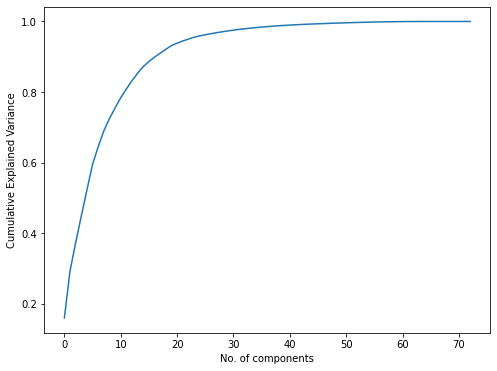

In [ ]:
pca = PCA().fit(X_train)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No. of components')
plt.ylabel('Cumulative Explained Variance')

In [ ]:
pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)